In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [29]:
from astropy.table import Table
import astropy.units as u
import astropy.constants as c

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [31]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)
color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [32]:
# mjd, mag, mag_unc
# upper limits: mag = 5sigma, mag_unc = -999
X = np.loadtxt('SN2020jgb_ZTF_g_snr3.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r_snr3.dat')

In [33]:
tfo = min(X[np.argwhere(X[:, -1] > 0)[0], 0], Y[np.argwhere(Y[:, -1] > 0)[0],
                                                0])[0]
tno = max(X[np.argwhere(X[:, -1] > 0)[0] - 1, 0],
          Y[np.argwhere(Y[:, -1] > 0)[0] - 1, 0])[0]
tfl = (tfo + tno) / 2
tfl_unc = (tfo - tno) / 2
print(tfl, tfl_unc)

58969.470214999994 2.992744999999559


In [34]:
tp = 58986.41
z = 0.0307

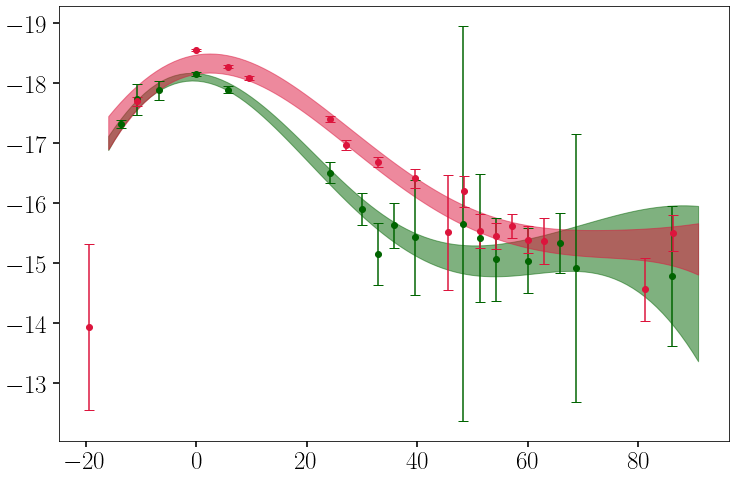

In [35]:
X = np.loadtxt('SN2020jgb_ZTF_g_snr1.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r_snr1.dat')

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(
    1e-1, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e0))

tG = np.atleast_2d(X[X[:, 2] > 0, 0]).T
gmag = X[X[:, 2] > 0, 1]
gmag_unc = X[X[:, 2] > 0, 2]

tR = np.atleast_2d(Y[Y[:, 2] > 0, 0]).T
rmag = Y[Y[:, 2] > 0, 1]
rmag_unc = Y[Y[:, 2] > 0, 2]

gpG = GPR(kernel=kernel, alpha=gmag_unc**2, n_restarts_optimizer=10)
gpG.fit(tG, gmag)
gpR = GPR(kernel=kernel, alpha=rmag_unc**2, n_restarts_optimizer=50)
gpR.fit(tR, rmag)

tgp = np.linspace(58970, 59080, 100)
tgp = np.atleast_2d(tgp).T
gmag_pred, dgmag_pred = gpG.predict(tgp, return_std=1)
rmag_pred, drmag_pred = gpR.predict(tgp, return_std=1)

plt.figure(figsize=(12, 8))
plt.errorbar((tG.ravel() - tp) / (1 + z),
             gmag,
             yerr=gmag_unc,
             fmt='o',
             capsize=5,
             color='darkgreen')
plt.fill_between((tgp.ravel() - tp) / (1 + z),
                 gmag_pred.ravel() - dgmag_pred.ravel(),
                 gmag_pred.ravel() + dgmag_pred.ravel(),
                 color='darkgreen',
                 alpha=0.5)
plt.errorbar((tR.ravel() - tp) / (1 + z),
             rmag,
             yerr=rmag_unc,
             fmt='o',
             capsize=5,
             color='crimson')
plt.fill_between((tgp.ravel() - tp) / (1 + z),
                 rmag_pred.ravel() - drmag_pred.ravel(),
                 rmag_pred.ravel() + drmag_pred.ravel(),
                 color='crimson',
                 alpha=0.5)
plt.gca().invert_yaxis()

# Abi's models

## g, r

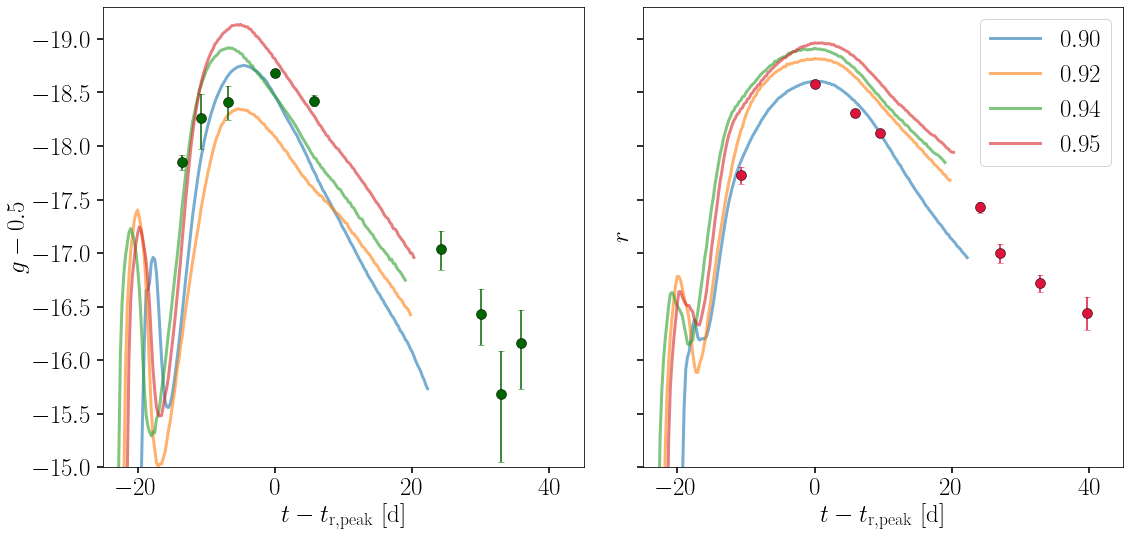

In [36]:
model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()

X = np.loadtxt('SN2020jgb_ZTF_g_snr2.dat')
Y = np.loadtxt('SN2020jgb_ZTF_r_snr2.dat')

tG = np.atleast_2d(X[X[:, 2] > 0, 0]).T
gmag = X[X[:, 2] > 0, 1]
gmag_unc = X[X[:, 2] > 0, 3:].T

tR = np.atleast_2d(Y[Y[:, 2] > 0, 0]).T
rmag = Y[Y[:, 2] > 0, 1]
rmag_unc = Y[Y[:, 2] > 0, 3:].T

f, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    mass = float(mod[pos + 5:][:mod[pos + 5:].find('_')])
    if mass == 0.89:
        continue
    mass = '${:.2f}$'.format(mass)
    dat = np.loadtxt(mod)
    if (-19.0 < dat[:, 3].min() < -17.0) and (-18.7 < dat[:, 2].min() < -16.7):
        ax[0].plot(dat[:-10, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:-10, 2] - .5,
                   linewidth=3,
                   alpha=0.6)  #g-band
        ax[1].plot(dat[:-10, 0] - dat[np.argmin(dat[:, 3]), 0],
                   dat[:-10, 3],
                   linewidth=3,
                   label=mass,
                   alpha=0.6)  #r-band
ax[0].errorbar(
    (tG.ravel() - tp) / (1 + z),
    gmag - .5,
    #xerr=2 / (1 + z),
    yerr=gmag_unc,
    fmt='o',
    markersize=10,
    capsize=3,
    markeredgecolor='k',
    markeredgewidth=.5,
    color='darkgreen')
ax[1].errorbar(
    (tR.ravel() - tp) / (1 + z),
    rmag,
    #xerr=2 / (1 + z),
    yerr=rmag_unc,
    fmt='o',
    markersize=10,
    capsize=3,
    markeredgecolor='k',
    markeredgewidth=.5,
    color='crimson')
ax[0].invert_yaxis()
ax[0].set_ylim(-15, -19.3)
ax[0].set_xlim(-25, 45)
ax[0].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[1].set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax[0].set_ylabel('$g-0.5$')
ax[1].set_ylabel('$r$')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

In [37]:
import h5py
from matplotlib import cm

['Lnu', 'click', 'mu', 'mu_edges', 'nu', 'nu_edges', 'phi', 'phi_edges', 'time', 'time_edges']
Synthesized lc, 0.85 + 0.10, rmax at 16.62
Synthesized lc, 0.87 + 0.08, rmax at 20.35


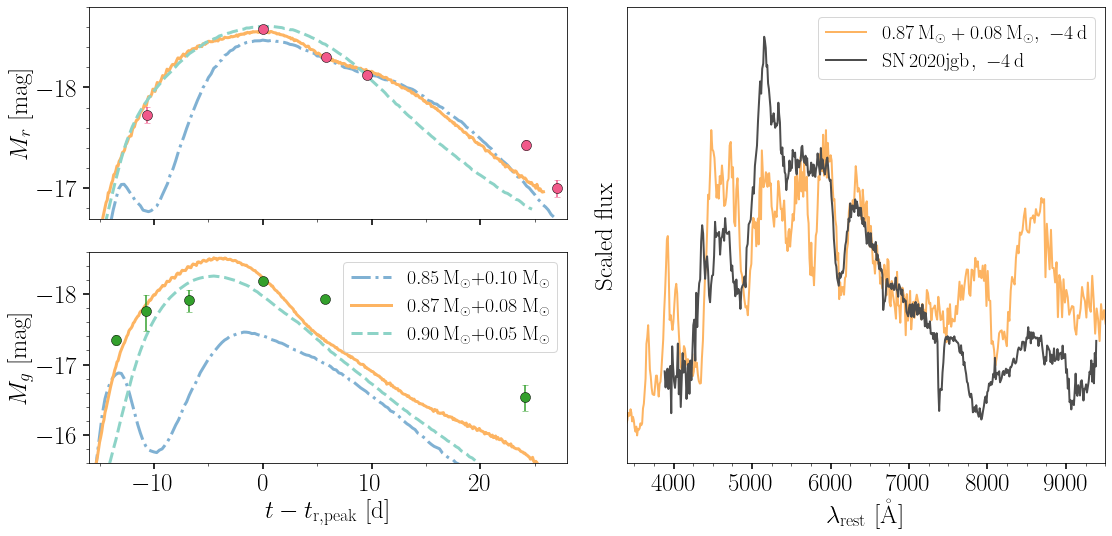

In [38]:
import astropy.constants as c
with h5py.File('../../Mtot0.95/0.87_0.08_doubledet.h5', 'r') as f:
    print(list(f.keys()))
    Lnu = np.array(f['Lnu'])
    t = np.array(f['time'][:] / 86400)
    nu = np.array(f['nu'][:])
    wv = (c.c / nu / u.Hz).to('angstrom').value

cmap = cm.get_cmap('Set3', 15)
colors = [cmap(i) for i in [6, 1, 5]]
lstyle = ['-', '--', '-.']
c = -1

f = plt.figure(figsize=(16, 8))
ax2 = plt.subplot(2, 2, 1)
ax1 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(1, 2, 2)

model = glob.glob('../../Mtot0.95/*lightcurve.dat')
model.sort()

for mod in model:
    m = mod.split('/')[-1]
    m = m.split('_')
    mc, ms = m[0], m[1]
    dat = np.loadtxt(mod)
    dat = dat[dat[:, -1] != 0]
    T = dat[:, 0]
    g = dat[:, 3]
    r = dat[:, 4]
    if float(mc) > 0.84:
        ax1.plot(T[:-10] - T[np.argmin(r)],
                 g[:-10],
                 linewidth=3,
                 label=r'${}\,$'.format(mc) + r'$\mathrm{M_\odot}$' +
                 r'$+{}\,$'.format(ms) + r'$\mathrm{M_\odot}$',
                 color=colors[c],
                 linestyle=lstyle[c])  #g-band
        ax2.plot(T[:-15] - T[np.argmin(r)],
                 r[:-15],
                 linewidth=3,
                 color=colors[c],
                 linestyle=lstyle[c])  #r-band
        c += 1
        print('Synthesized lc, {} + {}, rmax at {:.2f}'.format(
            mc, ms, T[np.argmin(r)]))

model = glob.glob('../../polin19_models/0.05s/*.mag')
model.sort()
for mod in model:
    pos = mod.find('good_')
    if pos == -1:
        #continue
        pos = mod.find('.05s/')
    mc = float(mod[pos + 5:][:mod[pos + 5:].find('_')])
    if mc != 0.90:
        continue
    dat = np.loadtxt(mod)
    ax1.plot(dat[:, 0] - dat[np.argmin(dat[:, 3]), 0],
             dat[:, 2],
             linewidth=3,
             label=r'${:.2f}\,$'.format(mc) + r'$\mathrm{M_\odot}$' +
             '$+0.05\,$' + r'$\mathrm{M_\odot}$',
             color=colors[c],
             linestyle=lstyle[c])  #g-band
    ax2.plot(dat[:, 0] - dat[np.argmin(dat[:, 3]), 0],
             dat[:, 3],
             linewidth=3,
             color=colors[c],
             linestyle=lstyle[c])  #r-band
    c += 1

ax1.errorbar(
    (tG.ravel() - tp) / (1 + z),
    gmag,
    #xerr=2 / (1 + z),
    yerr=gmag_unc,
    fmt='o',
    markersize=10,
    capsize=3,
    markeredgecolor='k',
    markeredgewidth=.5,
    color=color_map['green'])
ax2.errorbar(
    (tR.ravel() - tp) / (1 + z),
    rmag,
    #xerr=2 / (1 + z),
    yerr=rmag_unc,
    fmt='o',
    markersize=10,
    capsize=3,
    markeredgecolor='k',
    markeredgewidth=.5,
    color=color_map['magenta'])
ax1.invert_yaxis()
ax2.invert_yaxis()
ax1.set_ylim(-15.6, -18.6)
ax2.set_ylim(-16.7, -18.8)
ax1.set_xlim(-16, 28)
ax2.set_xlim(-16, 28)
ax2.xaxis.set_ticklabels([])
ax1.set_xlabel('$t-t_\mathrm{r, peak}\ [\mathrm{d}]$')
ax1.set_ylabel('$M_g\ \mathrm{[mag]}$')
ax2.set_ylabel('$M_r\ \mathrm{[mag]}$')
ax1.legend(loc=1, prop={'size': 20})

#spectrum comparison
# NOT, -4d
obs = np.loadtxt('../../Mtot0.95/ZTF20aayhacx_20200513_NOT_v4_corrected.dat')
arg = np.argwhere(t == 16.35)

syn_bin = data_binning(np.array(
    [np.flip(wv[1:]),
     np.flip(Lnu[arg, 1:].ravel()),
     np.ones_like(wv[1:])]).T,
                       size=10)
ax3.plot(syn_bin[:, 0],
         syn_bin[:, 1] /
         np.median(Lnu[arg, np.where((wv < 7000) & (wv > 6000))].ravel()) / 0.9,
         label=r'$0.87\,\mathrm{M_\odot}+0.08\,\mathrm{M_\odot},\ -4\,\mathrm{d}$',
         color=colors[0],
         linewidth=2)

obs_bin = data_binning(obs, size=10)
ax3.plot(obs_bin[:, 0],
         obs_bin[:, 1] /
         np.median(obs[np.where((obs[:, 0] < 7000) & (obs[:, 0] > 6000)), 1]) / 0.9,
         label=r'$\mathrm{SN\,2020jgb},\ -4\,\mathrm{d}$',
         color='0.3',
         linewidth=2)
'''# SEDM, +4d
obs = np.loadtxt(
    '../spectroscopy/SN2020jgb/ZTF20aayhacx_20200521_P60_v2.ascii')
obs = obs[obs[:, 0] > 4500]
arg = np.argwhere(t == 24.35)

syn_bin = data_binning(np.array(
    [np.flip(wv[1:]),
     np.flip(Lnu[arg, 1:].ravel()),
     np.ones_like(wv[1:])]).T,
                       size=10)
ax3.plot(syn_bin[:, 0],
         syn_bin[:, 1] /
         np.median(Lnu[arg, np.where((wv < 7000) & (wv > 6000))].ravel()) -
         1.7,
         color=colors[0],
         linewidth=2)

obs_bin = data_binning(obs, size=10)
E = 10**(0.4 * calALambda(obs_bin[:, 0], 3.1, 0.404))  #reddening
ax3.plot(
    obs_bin[:, 0] / (1 + 0.0307),
    obs_bin[:, 1] * E / np.median(
        (obs[:, 1] * E)[np.where((obs[:, 0] < 7000) & (obs[:, 0] > 6000))]) - 1.7,
    color='0.3',
    linewidth=2)'''

ax3.legend(prop={'size': 20})
ax3.set_xlim(3400, 9500)
ax3.set_ylim(0, 2.5)
ax3.set_yticks([])
ax3.set_xticks(np.arange(4, 10) * 1000)
ax3.set_ylabel(r'$\mathrm{Scaled\ flux}$')
ax3.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\mathring{A}}]$')

for ax in [ax1, ax2]:
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))

ax3.xaxis.set_minor_locator(MultipleLocator(250))

plt.tight_layout()
plt.savefig('../paper/figures/model.pdf', bbox_inches='tight')
plt.show()

## g-r

In [39]:
# From Bulla, Miller+2020

gr_population = pd.read_csv('color/gr_adam.txt', 
                            delim_whitespace=True, comment='#',
                            names=['SN', 't', 'e_t_min', 'e_t_max', 
                                   'gr', 'e_gr_min', 'e_gr_max',
                                   'type', 'marker'])

normal_ia = np.where((gr_population.type == 'normal*') |
                     (gr_population.type == 'normal') | 
                     (gr_population.type == '91T-like') |
                     (gr_population.type == '99aa-like') | 
                     (gr_population.type == '99aa-like*')
                    )

print('There are {} normal SNe in this sample'.format(len(gr_population.iloc[normal_ia].SN.unique())))

gr_population.head(5)

There are 62 normal SNe in this sample


,SN,t,e_t_min,e_t_max,gr,e_gr_min,e_gr_max,type,marker
0,ZTF18aapqwyv,2.111188,0.685375,0.529521,0.242970,0.368273,0.384782,normal*,o
1,ZTF18aapqwyv,3.032216,0.685375,0.529521,0.945111,0.297778,0.358075,normal*,o
2,ZTF18aapqwyv,3.974450,0.685375,0.529521,0.270548,0.168496,0.161108,normal*,o
3,ZTF18aapqwyv,4.973797,0.685375,0.529521,0.125119,0.193820,0.177315,normal*,o
4,ZTF18aapqwyv,16.227165,0.685375,0.529521,-0.131547,0.033107,0.033027,normal*,o


In [40]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    mag1, mag2 = X[:, 1], Y[:, 1]
    if not flux:
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        unc1, unc2 = X[:, 3:], Y[:, 3:]
        f1, f2 = 10**(-0.4 * mag1), 10**(-0.4 * mag2)
        f_unc1 = (10**(-0.4 *
                       (mag1 - unc1[:, 0])) - 10**(-0.4 *
                                                   (mag1 + unc1[:, 1]))) / 2
        f_unc2 = (10**(-0.4 *
                       (mag2 - unc2[:, 0])) - 10**(-0.4 *
                                                   (mag2 + unc2[:, 1]))) / 2
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

In [41]:
# 11fe
fe_lc = Table.read('11fe.csv')
fe_lc = fe_lc[~np.isnan(fe_lc['e_magnitude'])]
fe_lc['Phase'] = (fe_lc['time'] - 55816.6) / (1 + 0.0008)
fe_lc['Phase_fl'] = (fe_lc['time'] - 55796.687) / (1 + 0.0008)
fe_lc = fe_lc[~fe_lc['e_magnitude'].mask]

fe_g = fe_lc[fe_lc['band'] == 'g']
fe_r = fe_lc[fe_lc['band'] == 'r']

distmod = 29.04 #\pm 0.19

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.0077

fe_g['Mag'] = fe_g['magnitude'] - distmod - calALambda(leff_g, rv, ebv)
fe_r['Mag'] = fe_r['magnitude'] - distmod - calALambda(leff_r, rv, ebv)

X = np.array([fe_g['Phase'], fe_g['Mag'], fe_g['e_magnitude']]).T
Y = np.array([fe_r['Phase'], fe_r['Mag'], fe_r['e_magnitude']]).T
fe_g_bin = data_binning(X, size=0.5)
fe_r_bin = data_binning(Y, size=0.5)

X = np.array([fe_g['Phase_fl'], fe_g['Mag'], fe_g['e_magnitude']]).T
Y = np.array([fe_r['Phase_fl'], fe_r['Mag'], fe_r['e_magnitude']]).T
X = data_binning(X, size=0.5)
Y = data_binning(Y, size=0.5)
dT_fe, dmag_fe, Unc_fe = mag1_mag2(X, Y, bin_size=0.8)

In [42]:
# 11fe
distmod = 29.04 #\pm 0.19
fe_g_syn = np.loadtxt('SN2011fe_g_synthetic.dat')
fe_g_syn[:, 0] = (fe_g_syn[:, 0] - 55816.6) / (1 + 0.0008) # w.r.t r peak
fe_g_syn[:, 1] = fe_g_syn[:, 1] - distmod
fe_r_syn = np.loadtxt('SN2011fe_r_synthetic.dat')
fe_r_syn[:, 0] = (fe_r_syn[:, 0] - 55816.6) / (1 + 0.0008) # w.r.t r peak
fe_r_syn[:, 1] = fe_r_syn[:, 1] - distmod
fe_g_r_syn = np.loadtxt('SN2011fe_g_r_synthetic.dat')
fe_g_r_syn[:, 0] = (fe_g_r_syn[:, 0] - 55796.687) / (1 + 0.0008) # w.r.t fl

In [43]:
# 16jhr
jhr_lc = Table.read('16jhr.csv')
jhr_lc = jhr_lc[~np.isnan(jhr_lc['e_magnitude'])]
jhr_lc['Phase'] = (jhr_lc['time'] - 57504) / (1 + 0.11737)
jhr_lc['Phase_fl'] = (jhr_lc['time'] - 57482) / (1 + 0.11737)
jhr_lc = jhr_lc[~jhr_lc['e_magnitude'].mask]

In [44]:
jhr_g = jhr_lc[(jhr_lc['band'] == 'g')]
jhr_r = jhr_lc[(jhr_lc['band'] == 'r')]

distmod = 38.69 # Jiang+2017, method part

leff_g = 4816.12  #AA
leff_r = 6234.11  #AA
rv = 3.1
ebv = 0.0263

jhr_g['Mag'] = jhr_g['magnitude'] - distmod - calALambda(leff_g, rv, ebv)
jhr_r['Mag'] = jhr_r['magnitude'] - distmod - calALambda(leff_r, rv, ebv)

X = np.array([jhr_g['Phase'], jhr_g['Mag'], jhr_g['e_magnitude']]).T
Y = np.array([jhr_r['Phase'], jhr_r['Mag'], jhr_r['e_magnitude']]).T
jhr_g_bin = data_binning(X, size=0.5)
jhr_r_bin = data_binning(Y, size=0.5)

X = np.array([jhr_g['Phase_fl'], jhr_g['Mag'], jhr_g['e_magnitude']]).T
Y = np.array([jhr_r['Phase_fl'], jhr_r['Mag'], jhr_r['e_magnitude']]).T
X = data_binning(X, size=1)
Y = data_binning(Y, size=1)
dT_jhr, dmag_jhr, Unc_jhr = mag1_mag2(X, Y, bin_size=1)
dmag_jhr = dmag_jhr[dT_jhr > 1]
Unc_jhr = Unc_jhr[dT_jhr > 1]
dT_jhr = dT_jhr[dT_jhr > 1]

In [45]:
# 18byg
byg_lc = Table.read('18byg.txt', format='ascii')
byg_lc = byg_lc[~np.isnan(byg_lc['e_omag'])]
byg_r = byg_lc[byg_lc['Filter'] == 'r']
byg_g = byg_lc[byg_lc['Filter'] == 'g']

In [46]:
z_byg = 0.066
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
distmod0 = cosmo.distmod(z=z_byg)

beta1 = z_byg
beta2 = ((1 + z_byg)**2 - 1) / ((1 + z_byg)**2 + 1)

DL = np.loadtxt('18byg_peculiar.dat')[6]  #H0 = 70
distmod = 5 * np.log10(DL * 1e6 / 10) * u.mag

leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
rv = 3.1
ebv = 0.011

byg_g['Mag'] = byg_g['omag'] - distmod.value - calALambda(leff_g, rv, ebv)
byg_r['Mag'] = byg_r['omag'] - distmod.value - calALambda(leff_r, rv, ebv)

In [47]:
calALambda(leff_g, rv, 0.404), calALambda(leff_r, rv, 0.404)

(1.5169161472474595, 1.0017554354796696)

In [48]:
tfl_byg = 58233.198 + 9.07 / 2

#photometry
X = np.array([(byg_g['MJD'] - tfl_byg) / (1 + 0.066), byg_g['Mag'],
              byg_g['e_omag']]).T
Y = np.array([(byg_r['MJD'] - tfl_byg) / (1 + 0.066), byg_r['Mag'],
              byg_r['e_omag']]).T
dT_byg, dmag_byg, Unc_byg = mag1_mag2(X, Y, bin_size=1)

#synthetic
color_byg = Table.read('color/gr_18byg.txt', format='ascii')
gr_byg = color_byg[color_byg['Filt'] == 'gr']
tp_byg = byg_r['MJD'][np.argmin(byg_r['omag'])]
gr_byg['Phase'] = (gr_byg['Epoch'] + tp_byg - tfl_byg) / (1 + 0.066)
dT_byg = np.append(dT_byg, gr_byg['Phase'])
dmag_byg = np.append(dmag_byg, gr_byg['Color'])
Unc_byg = np.append(Unc_byg, gr_byg['Err'])

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94753/845862577.py:48: RuntimeWarning: overflow encountered in power
  (mag1 - unc1[:, 0])) - 10**(-0.4 *
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94753/845862577.py:51: RuntimeWarning: overflow encountered in power
  (mag2 - unc2[:, 0])) - 10**(-0.4 *
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94753/845862577.py:64: RuntimeWarning: invalid value encountered in double_scalars
  t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94753/845862577.py:69: RuntimeWarning: divide by zero encountered in log10
  -2.5 * np.log10(f12 / (f12 + f12unc)))
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_94753/845862577.py:70: RuntimeWarning: invalid value encountered in log10
  Unc_l = np.append(Unc_l, -2.5 * np.log10(


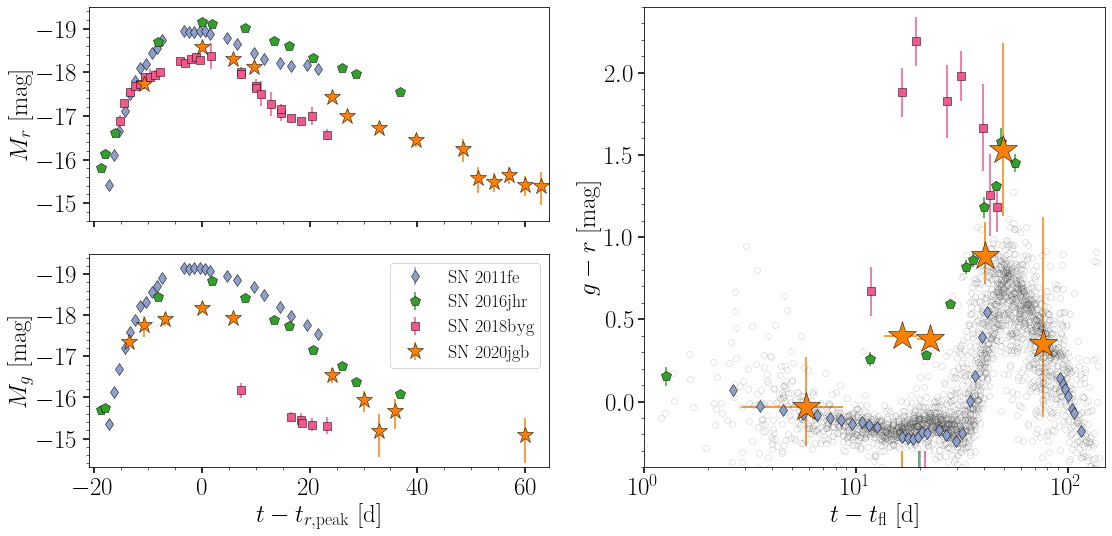

In [49]:
f = plt.figure(figsize=(16, 8))
ax2 = plt.subplot(2, 2, 1)
ax1 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(1, 2, 2)

col_11fe = color_map['blue']
col_16jhr = color_map['green']
col_18byg = color_map['magenta']
col_20jgb = color_map['orange']

#11fe
ax1.errorbar(fe_g_syn[:, 0],
             fe_g_syn[:, 1],
             yerr=fe_g_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe,
             label='$\mathrm{SN\ 2011fe}$')
ax2.errorbar(fe_r_syn[:, 0],
             fe_r_syn[:, 1],
             yerr=fe_r_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)

#16jhr
ax1.errorbar(jhr_g_bin[:, 0],
             jhr_g_bin[:, 1],
             yerr=jhr_g_bin[:, 2],
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr,
             label='$\mathrm{SN\ 2016jhr}$')
ax2.errorbar(jhr_r_bin[:, 0],
             jhr_r_bin[:, 1],
             yerr=jhr_r_bin[:, 2],
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr)

#18 byg
ax1.errorbar(byg_g['Phase'],
             byg_g['Mag'],
             yerr=byg_g['e_omag'],
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg,
             label='$\mathrm{SN\ 2018byg}$')
ax2.errorbar(byg_r['Phase'],
             byg_r['Mag'],
             yerr=byg_r['e_omag'],
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)

X1 = np.loadtxt('SN2020jgb_ZTF_g_snr1.dat')
Y1 = np.loadtxt('SN2020jgb_ZTF_r_snr1.dat')
X2 = np.loadtxt('SN2020jgb_ZTF_g_snr2.dat')
Y2 = np.loadtxt('SN2020jgb_ZTF_r_snr2.dat')

dT, dmag, Unc = mag1_mag2(X2, Y2, bin_size=1, flux=True)
Mag_pred, Mag_pred_unc = [], []
for x1, x2, ax in zip([X1, Y1], [X2, Y2], [ax1, ax2]):
    t = x2[x2[:, 2] > 0, 0]
    mag = x2[x2[:, 2] > 0, 1].copy()
    mag_unc = x2[x2[:, 2] > 0, 3:].T.copy()
    t_lim = x2[x2[:, 2] < 0, 0].copy()
    lim = x2[x2[:, 2] < 0, 1].copy()

    t1 = x1[x1[:, 2] > 0, 0]
    mag1 = x1[x1[:, 2] > 0, 1].copy()
    mag_unc1 = x1[x1[:, 2] > 0, 2].copy()

    ax.errorbar((t - tp) / (1 + z),
                mag,
                yerr=mag_unc,
                fmt='*',
                markersize=17,
                markeredgecolor='k',
                markeredgewidth=.5,
                color=col_20jgb,
                label='$\mathrm{SN\ 2020jgb}$')

    ax.set_xlim(-21, 64.5)
    ax.set_yticks([-15, -16, -17, -18, -19])

ax2.xaxis.set_ticklabels([])
ax2.set_ylabel(r'$M_r\ \mathrm{[mag]}$')

ax1.legend(prop={'size': 18})
ax1.set_xlabel(r'$t-t_{r,\mathrm{peak}}\ [\mathrm{d}]$')
ax1.set_ylabel(r'$M_g\ \mathrm{[mag]}$')

ax2.set_ylim(-19.5, -14.6)
ax1.set_ylim(-19.5, -14.3)
ax1.invert_yaxis()
ax2.invert_yaxis()

ax3.errorbar(fe_g_r_syn[:, 0],
             fe_g_r_syn[:, 1],
             yerr=fe_g_r_syn[:, 2],
             fmt='d',
             markersize=9,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_11fe)
ax3.errorbar(dT_jhr,
             dmag_jhr,
             yerr=Unc_jhr,
             fmt='p',
             markersize=10,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_16jhr)
ax3.errorbar(dT_byg,
             dmag_byg,
             yerr=Unc_byg,
             fmt='s',
             markersize=8,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_18byg)
ax3.errorbar((dT - tfl) / (1 + z),
             dmag,
             xerr=tfl_unc / (1 + z),
             yerr=Unc,
             fmt='*',
             markersize=30,
             markeredgecolor='k',
             markeredgewidth=.5,
             color=col_20jgb)
'''ax3.fill_between((tgp - tfl) / (1 + z),
                 gr_gp - gr_unc_gp,
                 gr_gp + gr_unc_gp,
                 color=col_20jgb,
                 alpha=0.5)'''
ax3.plot(gr_population.iloc[normal_ia].t.values,
         gr_population.iloc[normal_ia].gr.values,
         'o',
         color='None',
         mec='0.2',
         mew=0.4,
         ms=6,
         alpha=0.3)
ax3.set_ylim(-0.4, 2.4)
ax3.set_xlim(1, 150)
ax3.set_ylabel('$g-r\ \mathrm{[mag]}$')
ax3.set_xlabel('$t-t_\mathrm{fl}\ [\mathrm{d}]$')
ax3.set_xscale('log')

ax3.fill_between([(tp - tfl) / (1 + z) - .1, (tp - tfl) / (1 + z) + .1],
                 y1=[-0.4, -0.4],
                 y2=[-0.3, -0.3],
                 color=col_20jgb,
                 alpha=.7,
                 zorder=-10)
ax3.fill_between([(tp_byg - tfl_byg) / (1 + 0.066) - .1,
                  (tp_byg - tfl_byg) / (1 + 0.066) + .1],
                 y1=[-0.4, -0.4],
                 y2=[-0.3, -0.3],
                 color=col_18byg,
                 alpha=.7,
                 zorder=-10)
ax3.fill_between([(57504 - 57482) / (1 + 0.11737) - .1,
                  (57504 - 57482) / (1 + 0.11737) + .1],
                 y1=[-0.4, -0.4],
                 y2=[-0.3, -0.3],
                 color=col_16jhr,
                 alpha=.7,
                 zorder=-10)
ax3.fill_between([(55816.6 - 55796.687) / (1 + 0.0008) - .1,
                  (55816.6 - 55796.687) / (1 + 0.0008) + .1],
                 y1=[-0.4, -0.4],
                 y2=[-0.3, -0.3],
                 color=col_11fe,
                 alpha=.7,
                 zorder=-10)

for ax in [ax1, ax2]:
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))

ax3.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.savefig('../paper/figures/photometry.pdf', bbox_inches='tight')

In [50]:
def decline_rate(data, post=20):
    t = data[:, 0]
    mag = data[:, 1]
    tp = t[np.argmin(mag)]
    magp = np.min(mag)
    ref = np.argmin(np.abs(t - tp - post))
    rate = (mag[ref] - magp) / (t[ref] - tp)
    print(
        'closest obs: {:.2f}, rate: {:.3f} mag/d, Delta M{:.0f}: {:.2f}'.format(
            t[ref] - tp, rate, post, rate * post))

In [51]:
decline_rate(fe_g_bin)
decline_rate(jhr_g_bin)
decline_rate(np.array([byg_g['Phase'], byg_g['Mag']]).T, post=12)
decline_rate(X1) #20jgb

closest obs: 19.94, rate: 0.062 mag/d, Delta M20: 1.24
closest obs: 18.79, rate: 0.089 mag/d, Delta M20: 1.79
closest obs: 11.29, rate: 0.070 mag/d, Delta M12: 0.84
closest obs: 24.88, rate: 0.066 mag/d, Delta M20: 1.32


In [52]:
decline_rate(fe_g_syn, post=-14)
decline_rate(jhr_g_bin, post=-14)
decline_rate(X2, post=-14) #20jgb

closest obs: -13.89, rate: -0.274 mag/d, Delta M-14: 3.83
closest obs: -9.84, rate: -0.041 mag/d, Delta M-14: 0.57
closest obs: -13.95, rate: -0.060 mag/d, Delta M-14: 0.84
